In [1]:
import os
import warnings
from IPython.display import display, HTML
import platform
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import pathlib
import pickle #to save files
from itertools import product
from scipy.stats import skew, kurtosis, wilcoxon
from scipy.signal import butter, welch, filtfilt, resample
from scipy import stats
# import xgboost as xgb
# from xgboost.sklearn import XGBClassifier #this is the SKlearn wrapper
from sklearn.metrics import confusion_matrix, auc, f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn import svm
import time
import random
from PreprocessFcns import *
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

sns.set_context('talk',font_scale=1)
#-- For interactive plots--
# from mpl_toolkits.mplot3d import Axes3D
# %matplotlib notebook

In [2]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn import preprocessing
from sklearn import neighbors, linear_model
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.linear_model import ElasticNetCV, LogisticRegression
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

In [3]:
# get all data and remove useless rows
summary_info = pd.read_csv('//FS2.smpp.local//RTO//CIS-PD Study\\subj visit summary info.csv', index_col = 0)
Xtrain = pd.read_csv('//FS2.smpp.local/RTO/CIS-PD Study/Clinic WACC features/FeaturesHP_All_subjs.csv',index_col=0)
Xtrain = Xtrain[Xtrain.Subject!=1020]
Xtrain = Xtrain[~Xtrain['Tremor'].isnull()]
Xtrain = Xtrain[~Xtrain['Bradykinesia'].isnull()]

Xtrain = Xtrain.reset_index(drop= True)
for index, row in Xtrain.iterrows():
    if (row['Visit'] == '4 Weeks'):
        #print(row['Visit'])
        #print(Xtrain.loc[index, 'Visit'])
        #print(index)
        Xtrain.loc[index, 'Visit'] = '1 Month'
counter = 0
subjects = Xtrain['Subject'].unique()
features = pd.DataFrame()
for s in subjects:
    strain = Xtrain[Xtrain['Subject'] == s]
    visits = strain['Visit'].unique()
    # print(s.__str__() + ' visits: ' + visits)
    for v in visits:
        vtrain = strain[strain['Visit'] == v]
        mds = float('Nan')
        baseline_mds = float('Nan')
        
        try: 
            mds = int(summary_info.loc[(summary_info.VisitNm == v) & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            mds = float('Nan')
        try:
            baseline_mds = int(summary_info.loc[(summary_info.VisitNm == 'Baseline') & (summary_info["SubjectCode"] == s), 'MDS_score'])
        except:
            baseline_mds = float('Nan')
        if (np.isnan(mds) or np.isnan(baseline_mds)):
            #print(v + s.__str__())
            #counter += 1
            #display(vtrain)
            continue
        #display(vtrain)
        vtrain = vtrain.iloc[:, 5:-2]
        columns = vtrain.columns.values.tolist()

        cols = ['Subject', 'MDS score', 'Visit', 'baseline MDS']
        vals = [s, mds, v, baseline_mds]
        for c in columns:
            cols.append(c + " mean")
            cols.append(c + " var")
            vals.append(vtrain[c].mean())
            vals.append(vtrain[c].var())
            
        df = pd.DataFrame(data = [vals], columns = cols)
        if (not df.empty):
            counter += 1
        else:
            print(vals)
        features = features.append(df, ignore_index = True)
        

In [4]:
for index, row in features.iterrows():
    if (row['Visit'] == '1 Month'):
        features.loc[index, 'Visit'] = 3
    elif (row['Visit'] == '2 Weeks: Time 0'):
        features.loc[index, 'Visit'] = 1
    elif (row['Visit'] == '2 Weeks: Time 60'):
        features.loc[index, 'Visit'] = 2
features

,Subject,MDS score,Visit,baseline MDS,RMSX mean,RMSX var,RMSY mean,RMSY var,RMSZ mean,RMSZ var,...,PSD_std mean,PSD_std var,PSD_skew mean,PSD_skew var,PSD_kur mean,PSD_kur var,jerk_mean mean,jerk_mean var,jerk_std mean,jerk_std var
0,1016,19,1,20,0.004069,0.000009,0.006068,0.000050,0.004941,0.000036,...,0.001677,9.506376e-06,3.579956,1.462709,14.899901,92.664206,0.000091,4.985616e-07,0.053216,0.001760
1,1016,21,2,20,0.004030,0.000008,0.005652,0.000020,0.005489,0.000045,...,0.001495,6.207789e-06,3.532259,1.520124,14.551906,90.698890,0.000030,2.180829e-07,0.050629,0.001093
2,1016,32,3,20,0.004209,0.000010,0.005931,0.000026,0.005829,0.000057,...,0.001434,5.940771e-06,3.504365,1.557862,14.455093,92.683970,0.000047,2.655185e-07,0.054084,0.001657
3,1018,18,1,13,0.004221,0.000015,0.005597,0.000030,0.004696,0.000027,...,0.000960,2.036911e-06,3.393138,1.491039,13.761422,87.966827,-0.000007,2.571958e-07,0.050164,0.001500
4,1018,13,2,13,0.005074,0.000023,0.005855,0.000031,0.005253,0.000038,...,0.001150,2.396294e-06,3.486258,1.650707,14.442100,91.659130,0.000015,2.685295e-07,0.049711,0.001100
5,1018,14,3,13,0.005674,0.000029,0.007112,0.000040,0.005473,0.000040,...,0.001626,3.712757e-06,3.535584,1.763819,14.701650,94.373516,0.000025,3.729535e-07,0.059454,0.001779
6,1019,36,1,18,0.004645,0.000015,0.005396,0.000015,0.004298,0.000008,...,0.001134,2.796317e-06,3.552093,1.542282,14.634744,100.838031,-0.000067,1.990697e-07,0.058229,0.001620
7,1019,14,2,18,0.005892,0.000024,0.007727,0.000042,0.006619,0.000068,...,0.002283,1.452662e-05,3.360709,1.561567,13.149991,91.126949,-0.000004,4.998648e-07,0.072822,0.002568
8,1019,10,3,18,0.004328,0.000011,0.005961,0.000018,0.004678,0.000019,...,0.000942,1.040814e-06,3.499910,1.327562,14.137388,80.840255,-0.000020,2.224008e-07,0.055788,0.001234
9,1023,36,1,28,0.006958,0.000012,0.009098,0.000053,0.007421,0.000045,...,0.003037,2.972705e-05,3.234112,1.428213,12.449889,80.659598,-0.000024,7.276790e-07,0.093025,0.003586


In [109]:
a = []
p = []
subjects = features['Subject'].unique()

from sklearn.preprocessing import StandardScaler  
from sklearn.neural_network import MLPRegressor


for s in subjects:

    clf_MDS_RFR = RandomForestRegressor(n_estimators=50, random_state = 2)
    clf_MDS_NN = MLPRegressor(random_state = 2)
    # Xtrain, Xtest = train_test_split(final_features, test_size=0.3)
    Xtrain = features[features['Subject'] != s]
    ytrain = Xtrain['MDS score']
    ytrain = ytrain.values
    ytrain = ytrain.astype(int)
    Xtrain = Xtrain.iloc[:, 2:].as_matrix()
    
    # for neural network
    scaler = StandardScaler()  
    # Don't cheat - fit only on training data
    scaler.fit(Xtrain)  
    Xtrain_NN = scaler.transform(Xtrain)
    
    # could make more specific?
    clf_MDS_RFR.fit(Xtrain, ytrain)
    clf_MDS_NN.fit(Xtrain_NN, ytrain)
    
    Xtest = features[features['Subject'] == s]
    Xtest_NN = Xtest[(Xtest['baseline MDS'] <= 20) | (Xtest['baseline MDS'] >= 30)]
    Xtest_RFR = Xtest[(Xtest['baseline MDS'] > 20) & (Xtest['baseline MDS'] < 30)]
    
    # to use either NN or RFR for all data:
    # Xtest_RFR = Xtest
    # Xtest_NN = pd.DataFrame()
    
    # Xtest = Xtest[(Xtest['baseline MDS'] > 20) & (Xtest['baseline MDS'] < 30)]
    if (not Xtest_NN.empty):
        actual_NN = Xtest_NN['MDS score'].values.astype(int)
        a += list(actual_NN)
        Xtest_NN = Xtest_NN.iloc[:, 2:].as_matrix()
        # for neural network
        # apply same transformation to test data
        Xtest_NN = scaler.transform(Xtest_NN) 
        predictions_NN = clf_MDS_NN.predict(Xtest_NN)
        p += list(predictions_NN)
        
    if (not Xtest_RFR.empty):
        actual_RFR = Xtest_RFR['MDS score'].values.astype(int)
        a += list(actual_RFR)
        Xtest_RFR = Xtest_RFR.iloc[:, 2:].as_matrix()
        predictions_RFR = clf_MDS_RFR.predict(Xtest_RFR)
        p += list(predictions_RFR)
    
    # mse = float(np.mean((actual - predictions)**2))
    # print(mse)
#     print(predictions)
#     print(actual)
#     print('\n\n\n')


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:42: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
C:\ProgramData

35
87.81108218862246
0.4533941526723264


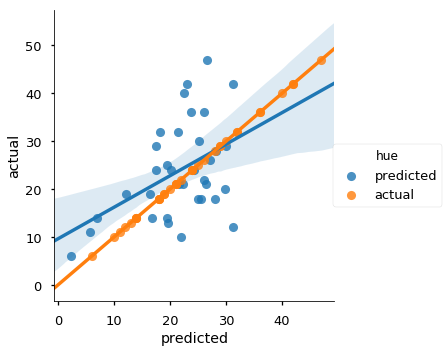

In [110]:
print(len(a))
i = []
for item in a:
    i += ['predicted']
for item in a:
    i += ['actual']
actual = np.array(a)
predictions = np.array(p)
mse = float(np.mean((actual - predictions)**2))
print(mse)

print(np.corrcoef(p, a)[0][1])
    
p += a
a += a
actual = np.array(a)
predictions = np.array(p)

df = pd.DataFrame()
df.insert(loc = len(df.columns.values), column = 'predicted', value = predictions)
df.insert(loc = len(df.columns.values), column = 'actual', value = actual)
df.insert(loc = len(df.columns.values), column = 'hue', value = i)
sns.lmplot(x = 'predicted', y = 'actual', hue = 'hue', data = df, order = 1)